In [1]:
import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt

## Loading results

In [2]:
DIR = {
    'SLTF': 'results/SL_TF_distilroberta-base_wiki_50_20000/',
    'ALTF': 'results/AL_TF_wiki_50_20000/',
}

In [67]:
# supervised_learning
results_dict_sl = {}
for seed in range(5):
    file_name = f'{DIR["SLTF"]}results_seed_{seed}.txt'
    with open(file_name, 'r') as f:
        results_dict_sl[seed] = json.load(f)
        
# contrastive
with open('./results/AL_TF_wiki_50_20000_ContrastiveActiveLearning_BalancedWeak/END_2024-06-19 01:45:40.148421.json', 'r') as f:
    results_dict_con = json.load(f)
    
# least confidence
with open('./results/AL_TF_wiki_50_20000_LeastConfidence_BalancedWeak/END_2024-06-18 07:28:27.755587.json', 'r') as f:
    results_dict_lc = json.load(f)
    

In [4]:
def get_f1s_sl(results_dict):
    f1s = {
        key : [] for key in results_dict[0].keys()
    }
    for seed, results in results_dict.items():
        for dataset, result in results.items():
            f1s[dataset].append(result['eval_f1-score'])
    return f1s

def iter_to_num_examples (iteration, total_iter):
        return iteration * 50 + 20 if iteration < total_iter else 2000

def get_al_results(results_dict):
    total_iter = len([int(x) for x in results_dict['results_dict']['run_0'].keys()])
    total_seed = len(results_dict['results_dict'].keys())

    list_of_datasets = ['test_base_f1', 'test_50_f1', 'test_10_f1', 'test_5_f1']
    f1s_al = {key:np.zeros((total_iter, total_seed)) for key in list_of_datasets}
    n_per_iter = [iter_to_num_examples(i, total_iter) for i in range(41)]
    
    for seed, results in results_dict['results_dict'].items():
        seed_int = int(seed.split('_')[1])
        for iteration, iter_result in results.items():
            for dataset in list_of_datasets:
                f1s_al[dataset][int(iteration), seed_int]=iter_result[dataset]
    return f1s_al, n_per_iter
    

In [68]:
f1s_sl = get_f1s_sl(results_dict_sl)
f1s_con, n_per_iter = get_al_results(results_dict_con)
f1s_lc, n_per_iter = get_al_results(results_dict_lc)

In [32]:
# get mean and std from SL without AL
dict_out = {}
ninety_percent_F1 = {}
for k, v in f1s_sl.items():
    dict_out[k] = (np.mean(v), np.std(v), 0.9*np.mean(v))
    ninety_percent_F1[k] = 0.9*np.array(v)
dict_out

{'validation': (0.9118051679424383, 0.00941108003812174, 0.8206246511481945),
 'test_base': (0.8187383725955852, 0.044132840488895195, 0.7368645353360267),
 'test_50': (0.9192653743797555, 0.0065554397178385106, 0.82733883694178),
 'test_10': (0.8154134359494367, 0.04142386723301071, 0.733872092354493),
 'test_5': (0.7450269618835145, 0.05392903229465319, 0.670524265695163)}

In [15]:
# get max from AL_LC
dict_out = {}
for k, v in f1s_lc.items():
    dict_out[k] = np.max(v)
dict_out

{'test_base_f1': 0.8540082668173263,
 'test_50_f1': 0.9243564293032787,
 'test_10_f1': 0.8487662704734497,
 'test_5_f1': 0.7943017485565829}

In [70]:
# get max from AL_CAL
dict_out = {}
for k, v in f1s_con.items():
    dict_out[k] = np.max(v)
dict_out

{'test_base_f1': 0.8651027377549259,
 'test_50_f1': 0.9189998412396889,
 'test_10_f1': 0.8581930006766221,
 'test_5_f1': 0.8074430145839437}

In [66]:
dict_out = {k:[] for k in f1s_lc.keys()}
for s in range(5):
    for k, v in f1s_lc.items():
        dict_out[k].append([x for x, y in zip(n_per_iter, v[:,s]) if y>ninety_percent_F1[k[:-3]][s]][0])
for k, v in dict_out.items():
    print(f'{k}: {np.mean(v)}, {np.std(v)}')
dict_out

test_base_f1: 270.0, 89.44271909999159
test_50_f1: 190.0, 24.49489742783178
test_10_f1: 260.0, 96.95359714832658
test_5_f1: 380.0, 287.0540018881465


{'test_base_f1': [120, 370, 320, 320, 220],
 'test_50_f1': [170, 170, 220, 220, 170],
 'test_10_f1': [120, 370, 320, 320, 170],
 'test_5_f1': [120, 620, 120, 820, 220]}

In [72]:
dict_out = {k:[] for k in f1s_con.keys()}
for s in range(5):
    for k, v in f1s_con.items():
        dict_out[k].append([x for x, y in zip(n_per_iter, v[:,s]) if y>ninety_percent_F1[k[:-3]][s]][0])
for k, v in dict_out.items():
    print(f'{k}: {np.mean(v)}, {np.std(v)}')
dict_out

test_base_f1: 370.0, 137.84048752090223
test_50_f1: 280.0, 58.309518948453004
test_10_f1: 370.0, 137.84048752090223
test_5_f1: 460.0, 198.4943324127921


{'test_base_f1': [170, 570, 320, 320, 470],
 'test_50_f1': [170, 320, 320, 270, 320],
 'test_10_f1': [170, 570, 320, 320, 470],
 'test_5_f1': [170, 620, 320, 720, 470]}

## plot

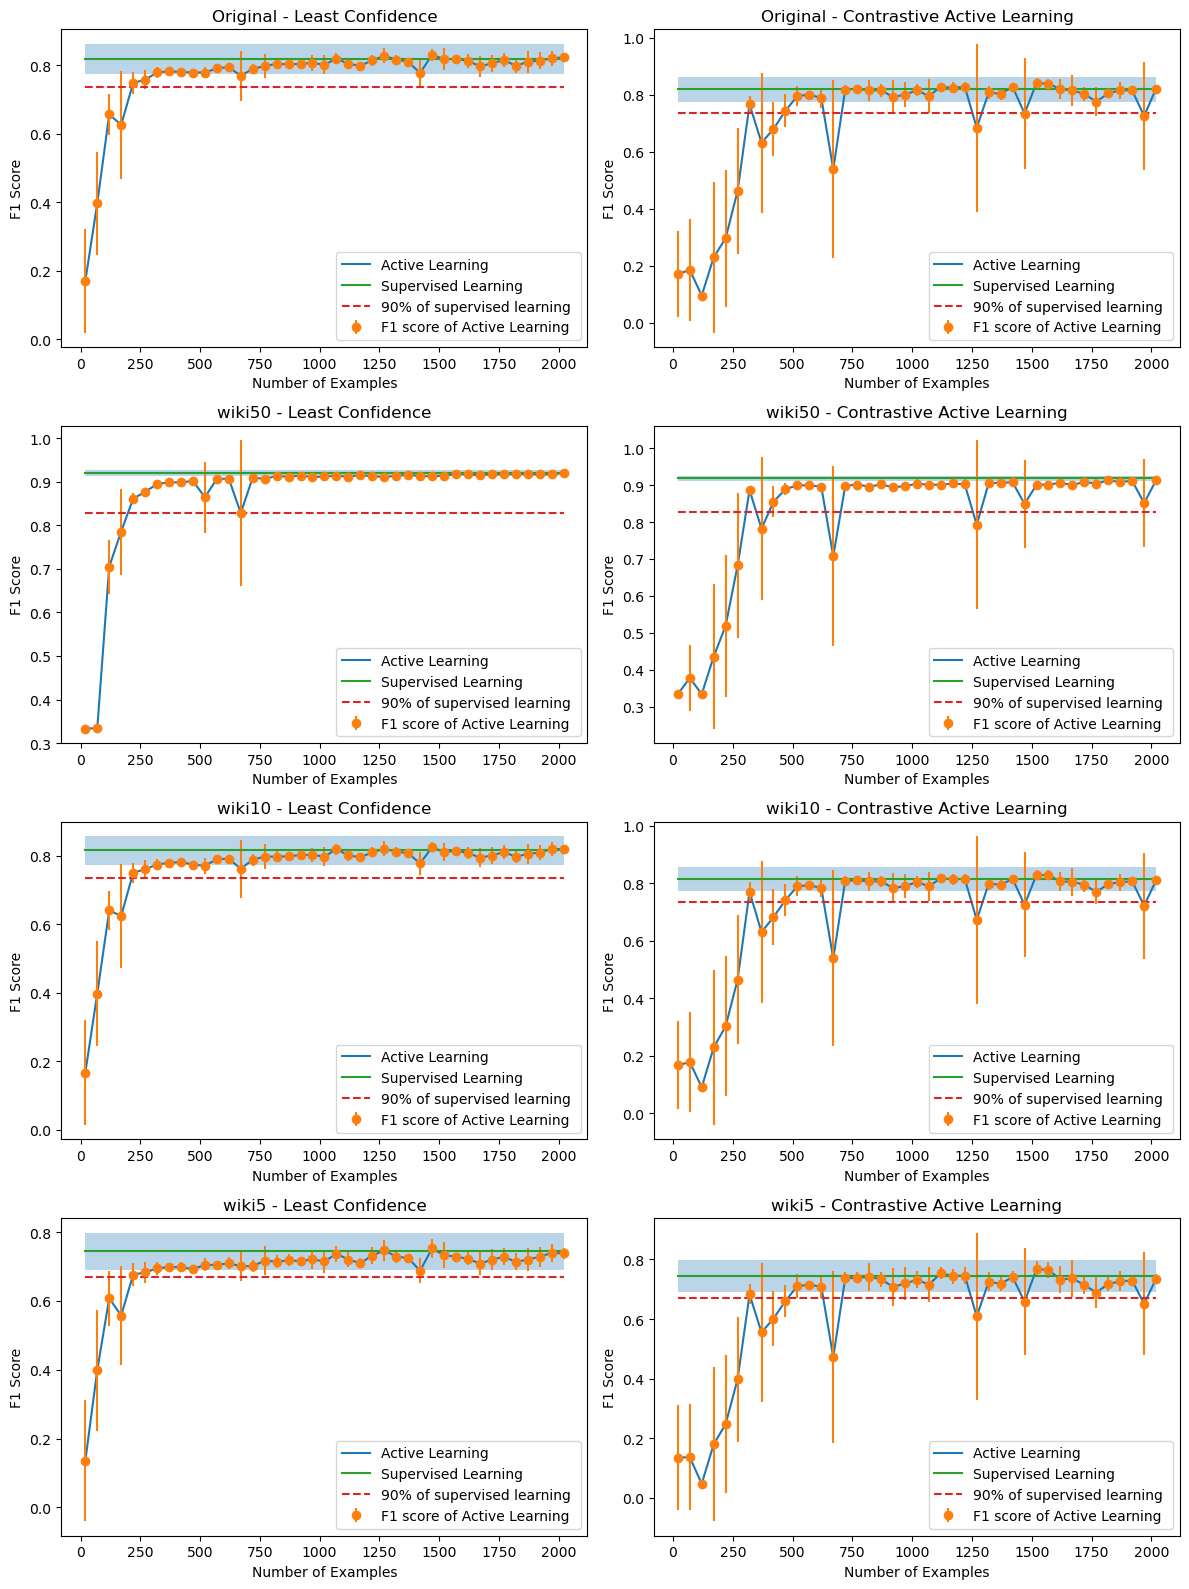

In [80]:
# Define the datasets and active learning methods
datasets = ['test_base', 'test_50', 'test_10', 'test_5']
ds_name_to_title = {'test_base':'Original', 'test_50':'wiki50', 'test_10':'wiki10', 'test_5':'wiki5'}
al_methods = ['lc', 'con']
al_method_to_title = {'lc':'Least Confidence', 'con':'Contrastive Active Learning'}


# Create a new figure and axis with a 4 by 2 grid
fig, axs = plt.subplots(4, 2, figsize=(12, 16))

# Iterate over the datasets and active learning methods
for i, dataset in enumerate(datasets):
    # Define the x-axis values (number of examples)
    x = n_per_iter

    # Define the y-axis values for the horizontal line - supervised learning
    y_horizontal = np.average(f1s_sl[f'{dataset}'])
    y_std_sl = np.std(f1s_sl[f'{dataset}'])
    
    for j, al_method in enumerate(al_methods):
        if al_method == 'lc':
            f1_scores = f1s_lc[f'{dataset}_f1']
        else:
            f1_scores = f1s_con[f'{dataset}_f1']
        # Get the f1 scores and number of examples for the current dataset and active learning method
        y_f1_score = np.average(f1_scores,axis=1)

        
        # Get the average f1 scores and standard deviations
        avg_f1_scores = np.average(f1_scores, axis=1)
        std_f1_scores = np.std(f1_scores, axis=1)
        
        # Get the x and y values for the current graph
        # x = n_examples
        y = avg_f1_scores
        
        # Get the standard deviation values for error bars
        y_err = std_f1_scores
        
        # Get the current axis for the graph
        ax = axs[i, j]
        
        # Plot the graph
        ax.plot(x, y, label='Active Learning')
        ax.errorbar(x, y, yerr=y_err, fmt='o', label='F1 score of Active Learning')
        
        # plot supervised learning performance
        ax.plot(x, np.repeat(y_horizontal, len(x)), label='Supervised Learning')
        # ax.errorbar(x, y_f1_score, yerr=y_std_con, fmt='o', label='Standard Deviation')
        ax.fill_between(x, y_horizontal - y_std_sl, y_horizontal + y_std_sl, alpha=0.3)

        # Plot 90% of the horizontal line
        ax.plot(x, np.repeat(y_horizontal*.9, len(x)), label='90% of supervised learning ', linestyle='--')
        
        # Set the x-axis label
        ax.set_xlabel('Number of Examples')
        
        # Set the y-axis label
        ax.set_ylabel('F1 Score')
        
        # Set the title of the graph
        ax.set_title(f'{ds_name_to_title[dataset]} - {al_method_to_title[al_method]}')
        
        # Add a legend
        ax.legend()

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()


In [17]:
from scipy.stats import mannwhitneyu, ttest_ind

# Define the datasets and active learning methods
datasets = ['test_base', 'test_50', 'test_10', 'test_5']
al_methods = ['lc', 'con']

# Perform the Mann-Whitney U test for each dataset
for dataset in datasets:
    for al_method1 in al_methods:
        for al_method2 in al_methods:
            if al_method1 != al_method2:
                f1_scores1 = f1s_lc[f'{dataset}_f1'] if al_method1 == 'lc' else f1s_con[f'{dataset}_f1']
                f1_scores2 = f1s_lc[f'{dataset}_f1'] if al_method2 == 'lc' else f1s_con[f'{dataset}_f1']
                
                # Perform the Mann-Whitney U test
                # _, p_value = mannwhitneyu(f1_scores1, f1_scores2, axis=1)
                _, p_value = ttest_ind(f1_scores1, f1_scores2, axis=1)
                
                # Determine if the average F1 score is statistically better or worse
                print(f"For dataset '{dataset}', {al_method1.upper()} vs {al_method2.upper()}:")
                for i, p in enumerate(p_value.tolist()):
                    if p < 0.05:
                        result = 'statistically different'
                    else:
                        result = 'not statistically different'
                    
                    # Print the result
                    print(f'Iteration{i}: number of examples {iter_to_num_examples(i, 41), result}')


For dataset 'test_base', LC vs CON:
Iteration0: number of examples (20, 'not statistically different')
Iteration1: number of examples (70, 'statistically different')
Iteration2: number of examples (120, 'statistically different')
Iteration3: number of examples (170, 'statistically different')
Iteration4: number of examples (220, 'statistically different')
Iteration5: number of examples (270, 'statistically different')
Iteration6: number of examples (320, 'statistically different')
Iteration7: number of examples (370, 'statistically different')
Iteration8: number of examples (420, 'statistically different')
Iteration9: number of examples (470, 'not statistically different')
Iteration10: number of examples (520, 'not statistically different')
Iteration11: number of examples (570, 'not statistically different')
Iteration12: number of examples (620, 'not statistically different')
Iteration13: number of examples (670, 'not statistically different')
Iteration14: number of examples (720, 'not

/home/raymond/miniconda3/envs/sim/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:551: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, axis=axis, **kwds)


In [116]:
p_value

array([1.00000000e+00, 3.99685237e-02, 2.70666656e-06, 7.28967567e-03,
       7.37347997e-03, 2.54670903e-03, 5.31652026e-02, 6.39248995e-01,
       8.12408349e-02, 4.23917715e-02, 8.32593137e-01, 6.60264247e-01,
       6.65306475e-01, 3.50872075e-02, 4.80291227e-01, 9.63830404e-01,
       7.34924370e-01, 2.18804911e-01, 9.55901863e-01, 1.77644946e-01,
       1.85940864e-01, 5.26929681e-03, 5.69392265e-01, 6.87969084e-01,
       7.16533389e-01, 1.30599221e-01, 2.01391811e-01, 5.59983675e-01,
       7.80051318e-01, 2.08841873e-01, 1.10025365e-01, 3.99942445e-01,
       3.51787389e-01, 2.64808227e-01, 3.50374060e-01, 7.34004958e-01,
       2.39454972e-01, 4.14689391e-01, 3.39656171e-01, 5.73825991e-01,
       9.37609684e-01])